In [3]:
import pandas as pd
import numpy as np

import datetime
from datetime import timedelta

import requests
from urllib.parse import urlencode
import json

from scipy import stats
from scipy.stats import ttest_ind
from scipy.stats import normaltest
from scipy.stats import bootstrap
import pingouin as pg

import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

%matplotlib inline

/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedCacheFailedWarning: Failed to use cache while checking for outdated package.
Set the environment variable OUTDATED_RAISE_EXCEPTION=1 for a full traceback.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.4.0, the latest is 0.5.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


# ЗАДАНИЕ 1

<div class="alert alert-block alert-info">
Retention – один из самых важных показателей в компании. <br>Ваша задача – написать функцию, которая будет считать retention игроков (по дням от даты регистрации игрока). </div>



In [2]:
# загружаем таблицу с данными о регистрации, в качестве разделителя ;
df_reg = pd.read_csv('../shared/problem1-reg_data.csv', encoding='windows=1251', sep=';')
df_reg.head()

/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedCacheFailedWarning: Failed to use cache while checking for outdated package.
Set the environment variable OUTDATED_RAISE_EXCEPTION=1 for a full traceback.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.4.0, the latest is 0.5.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


,reg_ts,uid
0,911382223,1
1,932683089,2
2,947802447,3
3,959523541,4
4,969103313,5


In [3]:
# загружаем таблицу с данными о заходе пользователей, в качестве разделителя ;
df_auth = pd.read_csv('../shared/problem1-auth_data.csv', encoding='windows=1251', sep=';')
df_auth.head()

,auth_ts,uid
0,911382223,1
1,932683089,2
2,932921206,2
3,933393015,2
4,933875379,2


#### Проведем для начала предобработку и общий анализ наших данных

In [4]:
df_reg.shape

(1000000, 2)

In [5]:
df_auth.shape

(9601013, 2)

In [6]:
df_auth.uid.nunique()
# проверим уникальные записи, их столько же сколько и в таблице с регистрацией, всё ок

1000000

In [7]:
df_reg.isnull().sum()
# пропущенных значений нет

reg_ts    0
uid       0
dtype: int64

In [8]:
df_auth.isnull().sum()
# пропущенных значений нет

auth_ts    0
uid        0
dtype: int64

In [9]:
# посмотрим на типы данных
df_reg.dtypes 

reg_ts    int64
uid       int64
dtype: object

In [10]:
df_auth.dtypes

auth_ts    int64
uid        int64
dtype: object

In [11]:
df_reg.duplicated().sum()
# проверим на дубликаты

0

In [12]:
df_auth.duplicated().sum()
# проверим на дубликаты

0

судя по всему у нас в таблицах используется формат времени ts
преобразуем его в обычное время

In [13]:
# Преобразование столбца reg_ts в формат времени
df_reg['reg_ts'] = df_reg['reg_ts'].apply(lambda x: datetime.datetime.fromtimestamp(x))
df_reg.head()

,reg_ts,uid
0,1998-11-18 12:43:43,1
1,1999-07-23 02:38:09,2
2,2000-01-14 01:27:27,3
3,2000-05-28 18:19:01,4
4,2000-09-16 15:21:53,5


In [14]:
# Преобразование столбца reg_ts в формат времени
df_auth['auth_ts'] = df_auth['auth_ts'].apply(lambda x: datetime.datetime.fromtimestamp(x))
df_auth.head()

,auth_ts,uid
0,1998-11-18 12:43:43,1
1,1999-07-23 02:38:09,2
2,1999-07-25 20:46:46,2
3,1999-07-31 07:50:15,2
4,1999-08-05 21:49:39,2


### Для подсчета Retention будем использовать когортный анализ

<div class="alert alert-danger"><br>
Перед проведением когортного анализа определяют четыре параметра:<br>

Признак формирования когорты — действие, которое объединяет людей в группу:<br>
первый визит, покупка, установка, регистрация и т.п.<br>
У нас это будет дата регистрации<br>

Размер когорты — временной интервал: день, неделя, месяц.<br>
У нас это 1 день по условиям задания<br>

Отчетный период — время исследования поведения групп.<br>
Данны период будет предлагаться выбрать (дата регистрации и конец периода)<br>

Анализируемый ключевой показатель: ROI, Retention Rate, LTV и т.д.<br>
У нас это Retention Rate - т.е. когда пользователь совершил свой следующий заход (авторизовался) после регистрации<br>
</div>

In [15]:
# уберем лишнее из дат
df_reg['reg_ts'] = df_reg['reg_ts'].dt.strftime('%Y-%m-%d')
df_reg.head()

,reg_ts,uid
0,1998-11-18,1
1,1999-07-23,2
2,2000-01-14,3
3,2000-05-28,4
4,2000-09-16,5


In [16]:
df_auth['auth_ts'] = df_auth['auth_ts'].dt.strftime('%Y-%m-%d')
df_auth.head()

,auth_ts,uid
0,1998-11-18,1
1,1999-07-23,2
2,1999-07-25,2
3,1999-07-31,2
4,1999-08-05,2


In [17]:
# последняя дата в таблице с регистрациями 
df_reg.reg_ts.max()

'2020-09-23'

In [18]:
# для предварительного когортного анализа оставим данные только за последний месяц, чтобы сократить вычисления
df_test_reg =  df_reg.query('reg_ts >= "2020-09-01"')
df_test_reg.head()

,reg_ts,uid
963262,2020-09-01,1069810
963263,2020-09-01,1069811
963264,2020-09-01,1069812
963265,2020-09-01,1069813
963266,2020-09-01,1069814


In [19]:
df_test_auth =  df_auth.query('auth_ts >= "2020-09-01"')
df_test_auth.head()

,auth_ts,uid
9247286,2020-09-01,737562
9247287,2020-09-01,376336
9247288,2020-09-01,1069810
9247289,2020-09-01,13791
9247290,2020-09-01,807646


In [20]:
# объединяем таблицы
retention_table = pd.merge(df_test_reg, df_test_auth, on='uid') 
retention_table.head()

,reg_ts,uid,auth_ts
0,2020-09-01,1069810,2020-09-01
1,2020-09-01,1069810,2020-09-02
2,2020-09-01,1069810,2020-09-04
3,2020-09-01,1069811,2020-09-01
4,2020-09-01,1069811,2020-09-07


In [21]:
# остортируем в порядке возрастания 
retention_table.sort_values(['reg_ts', 'uid'])
retention_table

,reg_ts,uid,auth_ts
0,2020-09-01,1069810,2020-09-01
1,2020-09-01,1069810,2020-09-02
2,2020-09-01,1069810,2020-09-04
3,2020-09-01,1069811,2020-09-01
4,2020-09-01,1069811,2020-09-07
...,...,...,...
56218,2020-09-23,1110618,2020-09-23
56219,2020-09-23,1110619,2020-09-23
56220,2020-09-23,1110620,2020-09-23
56221,2020-09-23,1110621,2020-09-23


In [22]:
# проверим типы данных 
retention_table.dtypes

reg_ts     object
uid         int64
auth_ts    object
dtype: object

In [23]:
# Задаем дату для расчета retention, например 10 сентября 2020 года
start_period = "2020-09-10"
# Преобразование строки в объект datetime
start_period_dt = datetime.datetime.strptime(start_period, '%Y-%m-%d')
# Форматирование даты в нужный формат
start_period_formatted = start_period_dt.strftime('%Y-%m-%d')
# Возьмем период для расчета retention в 10 дней
end_period = "2020-09-20"
end_period_dt = datetime.datetime.strptime(end_period, '%Y-%m-%d')
end_period_formatted = end_period_dt.strftime('%Y-%m-%d')

In [24]:
# оставляем нужные нам данные 
retention_table = retention_table[(retention_table['reg_ts'] >= start_period_formatted) & (retention_table['reg_ts'] <= end_period_formatted)]
retention_table

,reg_ts,uid,auth_ts
27126,2020-09-10,1085739,2020-09-10
27127,2020-09-10,1085740,2020-09-10
27128,2020-09-10,1085741,2020-09-10
27129,2020-09-10,1085742,2020-09-10
27130,2020-09-10,1085744,2020-09-10
...,...,...,...
51582,2020-09-20,1105556,2020-09-20
51583,2020-09-20,1105556,2020-09-23
51584,2020-09-20,1105557,2020-09-20
51585,2020-09-20,1105558,2020-09-20


In [25]:
# группируем данные по дате регистрации и дате авторизации, 
# считаем число уникальных пользователей ( одна авторизация от пользователя)
# т.е. смотрим  для каждой даты регистрации в какие дни пользователи делали заходы в игру и сколько таких пользователей было
retention_table = retention_table.groupby(['reg_ts','auth_ts'],  as_index=False)\
                                   .agg({'uid':'nunique'})
retention_table

,reg_ts,auth_ts,uid
0,2020-09-10,2020-09-10,1609
1,2020-09-10,2020-09-11,29
2,2020-09-10,2020-09-12,71
3,2020-09-10,2020-09-13,74
4,2020-09-10,2020-09-14,70
...,...,...,...
94,2020-09-19,2020-09-23,67
95,2020-09-20,2020-09-20,1636
96,2020-09-20,2020-09-21,38
97,2020-09-20,2020-09-22,71


In [26]:
# посчитаем для каждого строки период когорты - разницу между авторизацией и регистрацией
retention_table['cogort_period'] = (pd.to_datetime(retention_table['auth_ts']) - pd.to_datetime(retention_table['reg_ts'])).dt.days
retention_table


,reg_ts,auth_ts,uid,cogort_period
0,2020-09-10,2020-09-10,1609,0
1,2020-09-10,2020-09-11,29,1
2,2020-09-10,2020-09-12,71,2
3,2020-09-10,2020-09-13,74,3
4,2020-09-10,2020-09-14,70,4
...,...,...,...,...
94,2020-09-19,2020-09-23,67,4
95,2020-09-20,2020-09-20,1636,0
96,2020-09-20,2020-09-21,38,1
97,2020-09-20,2020-09-22,71,2


In [27]:
# также сделаем период когорты не больше, чем рассматриваемый период регистраций юзеров (пригодится в дальнейшем для ровной таблички)
retention_table = retention_table[retention_table['cogort_period'] <= (end_period_dt - start_period_dt).days]
retention_table


,reg_ts,auth_ts,uid,cogort_period
0,2020-09-10,2020-09-10,1609,0
1,2020-09-10,2020-09-11,29,1
2,2020-09-10,2020-09-12,71,2
3,2020-09-10,2020-09-13,74,3
4,2020-09-10,2020-09-14,70,4
...,...,...,...,...
94,2020-09-19,2020-09-23,67,4
95,2020-09-20,2020-09-20,1636,0
96,2020-09-20,2020-09-21,38,1
97,2020-09-20,2020-09-22,71,2


In [28]:
# перевернем нашу таблицу
pivot_retention_table = retention_table.pivot(index='reg_ts', columns='cogort_period', values='uid')
pivot_retention_table

cogort_period,0,1,2,3,4,5,6,7,8,9,10
reg_ts,,,,,,,,,,,
2020-09-10,1609.0,29.0,71.0,74.0,70.0,112.0,93.0,110.0,80.0,66.0,98.0
2020-09-11,1611.0,23.0,64.0,63.0,99.0,102.0,111.0,101.0,79.0,63.0,90.0
2020-09-12,1614.0,29.0,66.0,64.0,65.0,102.0,111.0,93.0,75.0,83.0,84.0
2020-09-13,1617.0,36.0,72.0,64.0,81.0,100.0,107.0,84.0,78.0,81.0,72.0
2020-09-14,1620.0,32.0,63.0,69.0,94.0,102.0,111.0,111.0,72.0,55.0,NaN
2020-09-15,1622.0,37.0,65.0,73.0,98.0,93.0,113.0,87.0,46.0,NaN,NaN
2020-09-16,1625.0,34.0,67.0,72.0,81.0,99.0,125.0,65.0,NaN,NaN,NaN
2020-09-17,1627.0,27.0,67.0,71.0,96.0,101.0,90.0,NaN,NaN,NaN,NaN
2020-09-18,1630.0,35.0,69.0,74.0,76.0,73.0,NaN,NaN,NaN,NaN,NaN


In [29]:
# делим все столбцы на первый, чтобы почитать процент
pivot_retention_table = pivot_retention_table.div(pivot_retention_table[pivot_retention_table.columns[0]], axis = 0) 
pivot_retention_table

cogort_period,0,1,2,3,4,5,6,7,8,9,10
reg_ts,,,,,,,,,,,
2020-09-10,1.0,0.018024,0.044127,0.045991,0.043505,0.069608,0.057800,0.068365,0.049720,0.041019,0.060907
2020-09-11,1.0,0.014277,0.039727,0.039106,0.061453,0.063315,0.068901,0.062694,0.049038,0.039106,0.055866
2020-09-12,1.0,0.017968,0.040892,0.039653,0.040273,0.063197,0.068773,0.057621,0.046468,0.051425,0.052045
2020-09-13,1.0,0.022263,0.044527,0.039579,0.050093,0.061843,0.066172,0.051948,0.048237,0.050093,0.044527
2020-09-14,1.0,0.019753,0.038889,0.042593,0.058025,0.062963,0.068519,0.068519,0.044444,0.033951,NaN
2020-09-15,1.0,0.022811,0.040074,0.045006,0.060419,0.057337,0.069667,0.053637,0.028360,NaN,NaN
2020-09-16,1.0,0.020923,0.041231,0.044308,0.049846,0.060923,0.076923,0.040000,NaN,NaN,NaN
2020-09-17,1.0,0.016595,0.041180,0.043639,0.059004,0.062077,0.055317,NaN,NaN,NaN,NaN
2020-09-18,1.0,0.021472,0.042331,0.045399,0.046626,0.044785,NaN,NaN,NaN,NaN,NaN


In [30]:
# Красиво оформляем
ur_style = (pivot_retention_table
            .style
            .set_caption('User retention by cohort')  # добавляем подпись
            .background_gradient(cmap='YlGn')  # раскрашиваем ячейки по столбцам
            .highlight_null('white')  # делаем белый фон для значений NaN
            .format("{:.2%}", na_rep=""))  # числа форматируем как проценты, NaN заменяем на пустоту     
ur_style

cogort_period,0,1,2,3,4,5,6,7,8,9,10
reg_ts,,,,,,,,,,,
2020-09-10,100.00%,1.80%,4.41%,4.60%,4.35%,6.96%,5.78%,6.84%,4.97%,4.10%,6.09%
2020-09-11,100.00%,1.43%,3.97%,3.91%,6.15%,6.33%,6.89%,6.27%,4.90%,3.91%,5.59%
2020-09-12,100.00%,1.80%,4.09%,3.97%,4.03%,6.32%,6.88%,5.76%,4.65%,5.14%,5.20%
2020-09-13,100.00%,2.23%,4.45%,3.96%,5.01%,6.18%,6.62%,5.19%,4.82%,5.01%,4.45%
2020-09-14,100.00%,1.98%,3.89%,4.26%,5.80%,6.30%,6.85%,6.85%,4.44%,3.40%,
2020-09-15,100.00%,2.28%,4.01%,4.50%,6.04%,5.73%,6.97%,5.36%,2.84%,,
2020-09-16,100.00%,2.09%,4.12%,4.43%,4.98%,6.09%,7.69%,4.00%,,,
2020-09-17,100.00%,1.66%,4.12%,4.36%,5.90%,6.21%,5.53%,,,,
2020-09-18,100.00%,2.15%,4.23%,4.54%,4.66%,4.48%,,,,,


### теперь просто сгруппируем весь наш код в функцию

In [31]:
def retention(start_period, end_period):
    df_reg = pd.read_csv('../shared/problem1-reg_data.csv', encoding='windows=1251', sep=';')
    df_auth = pd.read_csv('../shared/problem1-auth_data.csv', encoding='windows=1251', sep=';')
    df_reg['reg_ts'] = df_reg['reg_ts'].apply(lambda x: datetime.datetime.fromtimestamp(x))
    df_auth['auth_ts'] = df_auth['auth_ts'].apply(lambda x: datetime.datetime.fromtimestamp(x))
    df_reg['reg_ts'] = df_reg['reg_ts'].dt.strftime('%Y-%m-%d')
    df_auth['auth_ts'] = df_auth['auth_ts'].dt.strftime('%Y-%m-%d')
    retention_table = pd.merge(df_reg, df_auth, on='uid')
    retention_table.sort_values(['reg_ts', 'uid'])
    start_period_dt = datetime.datetime.strptime(start_period, '%Y-%m-%d')
    start_period_formatted = start_period_dt.strftime('%Y-%m-%d')
    end_period_dt = datetime.datetime.strptime(end_period, '%Y-%m-%d')
    end_period_formatted = end_period_dt.strftime('%Y-%m-%d')
    retention_table = retention_table[(retention_table['reg_ts'] >= start_period_formatted) & \
                                       (retention_table['reg_ts'] <= end_period_formatted)]
    retention_table = retention_table.groupby(['reg_ts','auth_ts'],  as_index=False)\
                                       .agg({'uid':'nunique'})
    retention_table['день возврата'] = (pd.to_datetime(retention_table['auth_ts']) - \
                                         pd.to_datetime(retention_table['reg_ts'])).dt.days
    retention_table = retention_table[retention_table['день возврата'] <= (end_period_dt - start_period_dt).days]
    pivot_retention_table = retention_table.pivot(index='reg_ts', columns='день возврата', values='uid')     
    pivot_retention_table = pivot_retention_table.div(pivot_retention_table[pivot_retention_table.columns[0]], axis = 0)
    pivot_retention_table.index.name = 'дата регистрации'
    ur_style = (pivot_retention_table
                .style
                .set_caption('<h1>Retention игроков по датам</h2>')
                .background_gradient(cmap='YlGn')
                .highlight_null('white')
                .format("{:.2%}", na_rep=""))
    return ur_style

<div class ="alert alert-success">тестируем</div> 

In [32]:
# retention('дата регистрации', 'дата окончания периода')
retention('2018-04-07', '2018-04-19')

день возврата,0,1,2,3,4,5,6,7,8,9,10,11,12
дата регистрации,,,,,,,,,,,,,
2018-04-07,100.00%,1.34%,4.81%,3.74%,4.28%,3.74%,8.29%,5.08%,4.55%,5.08%,3.74%,4.55%,4.81%
2018-04-08,100.00%,1.60%,3.47%,4.00%,4.53%,6.40%,7.47%,6.93%,3.47%,5.07%,4.80%,2.67%,7.20%
2018-04-09,100.00%,2.13%,4.53%,6.93%,4.27%,6.67%,6.93%,7.20%,3.20%,7.47%,7.20%,3.47%,5.87%
2018-04-10,100.00%,1.33%,5.05%,6.91%,4.26%,5.85%,6.12%,6.65%,4.79%,6.12%,4.79%,3.72%,4.79%
2018-04-11,100.00%,1.33%,4.77%,6.37%,5.84%,9.81%,5.57%,6.90%,6.37%,5.31%,5.31%,7.16%,5.57%
2018-04-12,100.00%,1.06%,3.98%,3.45%,5.04%,3.98%,5.04%,6.37%,2.39%,3.71%,5.04%,5.57%,3.98%
2018-04-13,100.00%,1.85%,5.03%,5.29%,5.82%,5.29%,8.73%,7.41%,5.82%,5.29%,5.03%,6.08%,4.23%
2018-04-14,100.00%,1.58%,2.64%,6.33%,5.28%,6.60%,5.54%,6.86%,5.54%,3.69%,5.80%,4.22%,4.75%
2018-04-15,100.00%,2.90%,4.49%,4.75%,4.22%,6.60%,6.07%,4.22%,4.49%,5.28%,3.96%,6.07%,5.28%


# ЗАДАНИЕ 2

<div class="alert alert-block alert-info">
Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений. <br> Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. <br> При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667.<br>
Какой набор предложений можно считать лучшим? <br> 
Какие метрики стоит проанализировать для принятия правильного решения и как?
    <div>

In [4]:
# ссылка на яндекс диск
public_path_1 = 'https://disk.yandex.ru/d/SOkIsD5A8xlI7Q'  

In [5]:
# Получаем загрузочную ссылку
def get_yandex(public_path):
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
    final_url = base_url + urlencode(dict(public_key=public_path))
    response = requests.get(final_url)
    download_url = response.json()['href']
    return download_url

df_AB = pd.read_csv(get_yandex(public_path_1), encoding='windows=1251', sep=';')
df_AB.head()

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b


#### Проведем для начала предобработку и общий анализ наших данных

In [6]:
df_AB.shape
# 404770 строчек, что соответсвует 202103+202667 кол-ву пользователей из задания

(404770, 3)

In [7]:
df_AB.dtypes 
# посмотрим на типы данных

user_id       int64
revenue       int64
testgroup    object
dtype: object

In [8]:
df_AB.isnull().sum()
# пропущенных значений нет

user_id      0
revenue      0
testgroup    0
dtype: int64

In [9]:
df_AB.duplicated().sum()
# проверим на дубликаты

0

In [10]:
df_AB.query('testgroup == "a"').user_id.nunique()
# кол-во уникальных пользователей в группе "а"

202103

In [11]:
df_AB.query('testgroup == "b"').user_id.nunique()
# кол-во уникальных пользователей в группе "b"

202667

<div class = "alert-success">делаем вывод, что группа а - контрольная, а группа b - тестовая <br>
сделаем для каждой свой датафрейм</div>

In [12]:
df_control = df_AB.query('testgroup == "a"')
df_control.head()

,user_id,revenue,testgroup
1,2,0,a
2,3,0,a
9,10,0,a
10,11,0,a
11,12,0,a


In [13]:
df_test = df_AB.query('testgroup == "b"')
df_test.head()

,user_id,revenue,testgroup
0,1,0,b
3,4,0,b
4,5,0,b
5,6,0,b
6,7,0,b


### Для оценки результатов теста будем использовать следующие метрики: <br>
**Конверсия (conversion rate, CR)** — отношение числа пользователей,  которые выполнили какое-либо целевое действие к общему числу пользователей. <br>
**ARPPU (Average revenue per paying user)** - Средний доход на платящего пользователя <br>
**ARPU (Average revenue per user)** - Cредний доход с привлечённого пользователя <br>


In [14]:
df_control_CR = df_control.query('revenue != 0').user_id.nunique() / df_control.user_id.nunique()*100
df_control_CR

0.9539690157988748

In [15]:
df_test_CR = df_test.query('revenue != 0').user_id.nunique() / df_test.user_id.nunique()*100
df_test_CR

0.8906235351586593

In [16]:
df_control_CR*100/df_test_CR

107.11248671740196

<div class = "alert-success"> В контрольной группе конверсия в покупателя больше на 7,11% </div>

In [17]:
df_control_ARPU = df_control.revenue.sum() / df_control.user_id.nunique()
df_control_ARPU

25.413719736965806

In [18]:
df_test_ARPU = df_test.revenue.sum() / df_test.user_id.nunique()
df_test_ARPU

26.75128659327863

In [19]:
df_test_ARPU*100/df_control_ARPU

105.2631683600699

<div class = "alert-success">ARPU в тестовой группе больше на 5,26% <br> 
*как и было указано в задании</div>

In [20]:
df_control_ARPPU = df_control.revenue.sum() / df_control.query('revenue != 0').user_id.nunique()
df_control_ARPPU

2663.9984439834025

In [21]:
df_test_ARPPU = df_test.revenue.sum() / df_test.query('revenue != 0').user_id.nunique()
df_test_ARPPU

3003.6581717451522

In [22]:
df_test_ARPPU*100/df_control_ARPPU

112.74999722799635

<div class = "alert-success">ARPPU в тестовой группе больше на 12.75%</div>

В условиях не сказано о каких суммах идет речь <br>
Если это миллионы, т.к. разница будет значительная <br>
Но если это просто допустим рубли, то разница ничтожна <br>
Поэтому ***оценим эти изменения на стат значимость*** <br>


### Начнем с конверсии

In [23]:
# делаем столбец с оплатой 1-да, 0-нет
df_AB['oplata'] = df_AB.revenue.apply(lambda x: 1 if x > 0 else 0)
df_AB.head()

,user_id,revenue,testgroup,oplata
0,1,0,b,0
1,2,0,a,0
2,3,0,a,0
3,4,0,b,0
4,5,0,b,0


In [24]:
# построим перекрестную таблицу с нужными для нас данными
pd.crosstab(df_AB.testgroup, df_AB.oplata)

oplata,0,1
testgroup,,
a,200175,1928
b,200862,1805


Проверим взаимосвязь платящих пользователей и группы с помощью статистического теста. <br>
Есть две категориальные переменные → нужен хи-квадрат <br>
нулевая гипотеза 𝐻0: взаимосвязи между переменными нет <br>
альтернативная гипотеза 𝐻1: взаимосвязь есть <br>

In [25]:
from scipy.stats import chi2_contingency, chi2 
stat, p, dof, expected = chi2_contingency(pd.crosstab(df_AB.testgroup, df_AB.oplata))
stat, p

(4.374729521260405, 0.03647561892312613)

<div class = "alert-success">p-value меньше 0,05 сл-но мы отклоняем нулевую гипотезу <br> 
т.е. изменение конверсии весьма вероятно взаимосвязано с введением нового алгоритма <br> 
а вероятность того, что это вызвано случайностью 3,6% <br> </div>

### Оплаты 

разбираемся теперь с платящими пользователями <br>
будем сравнивать средний доход в контрольной и тестовой группах

In [26]:
df_AB_oplata = df_AB.query('revenue > 0')
df_AB_oplata

,user_id,revenue,testgroup,oplata
72,73,351,a,1
160,161,3797,b,1
341,342,290,a,1
377,378,3768,b,1
385,386,250,a,1
...,...,...,...,...
404315,404316,262,a,1
404525,404526,3120,b,1
404543,404544,369,a,1
404602,404603,251,a,1


#### посмотрим на наши распределения платежей в группах

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


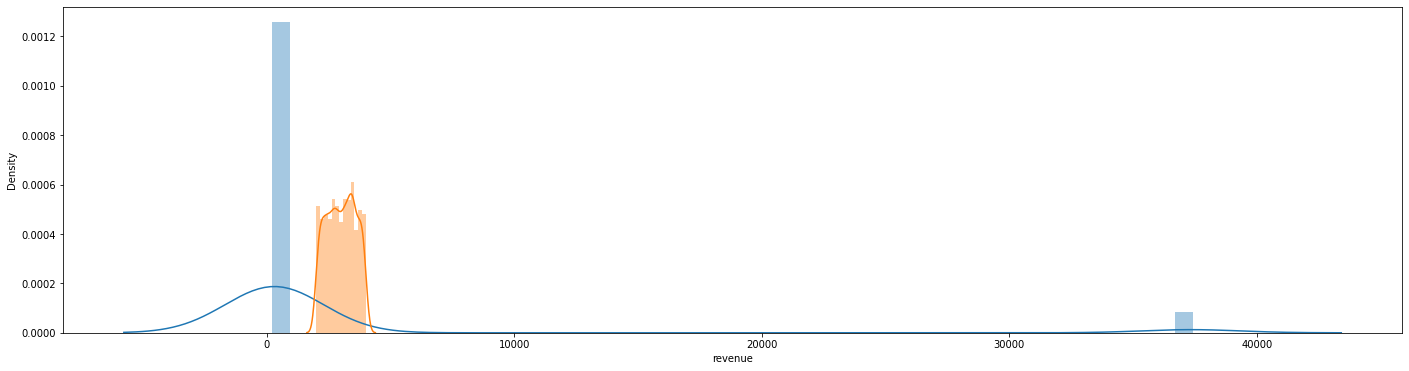

In [27]:
plt.figure(figsize=(24,6))
df_control_oplata = df_AB_oplata[df_AB_oplata.testgroup == 'a']
df_test_oplata = df_AB_oplata[df_AB_oplata.testgroup == 'b']
sns.distplot(df_control_oplata.revenue)
sns.distplot(df_test_oplata.revenue)

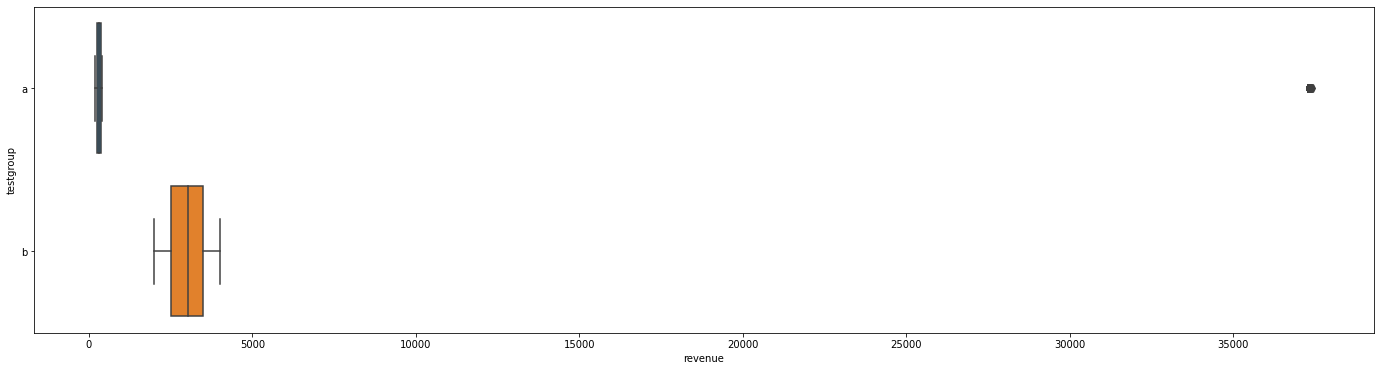

In [28]:
plt.figure(figsize=(24,6))
sns.boxplot(x='revenue', y='testgroup', data=df_AB_oplata)

In [29]:
df_control_oplata.revenue.mean()
#среднее в контрольной группе

2663.9984439834025

In [30]:
df_test_oplata.revenue.mean()
#среднее в тестовой группе

3003.6581717451522

In [31]:
# По графикам видно, что у нас есть выбросы в контрольной группе. 
df_control_oplata.query('revenue > 35000')

,user_id,revenue,testgroup,oplata
416,417,37324,a,1
4428,4429,37304,a,1
5777,5778,37315,a,1
8065,8066,37307,a,1
8743,8744,37334,a,1
...,...,...,...,...
360696,360697,37347,a,1
378668,378669,37297,a,1
389341,389342,37298,a,1
394580,394581,37302,a,1


123 пользователя с громадными платежами из 1928 платящих пользователей, а это больше 6%  <br>
их явно не стоит исключать <br>

Проверим выполнение условий на нормальность <br>
Вообще для выборок таких огромных размеров мы не обязаны это делать <br>
Обычно нормальность тестируют с помощью теста Шапиро-Уилка (scipy.stats.shapiro()), 
однако на больших выборках этот тест слишком рьяно находит отклонения от нормальности! <br>
Поэтому также используем функцию scipy.stats.normaltest() - она больше адаптирована к большим выборкам:<br>
нулевая гипотеза 𝐻0: распределения нормальные<br>
альтернативная гипотеза 𝐻1: данные распределены не нормально 

In [32]:
stats.shapiro(df_control_oplata.revenue)

ShapiroResult(statistic=0.2667924761772156, pvalue=0.0)

In [33]:
stats.shapiro(df_test_oplata.revenue)

ShapiroResult(statistic=0.9583123922348022, pvalue=2.491345674771425e-22)

In [34]:
stats.normaltest(df_control_oplata.revenue)

NormaltestResult(statistic=1394.9457843086925, pvalue=1.2341605505935488e-303)

In [35]:
stats.normaltest(df_test_oplata.revenue)

NormaltestResult(statistic=1068.8600084412267, pvalue=7.943249488371762e-233)

In [36]:
# Также можете сделать это через пакет pingouin.
pg.normality(data=df_AB_oplata, dv="revenue", 
                   group="testgroup", method="normaltest")

,W,pval,normal
a,1394.945784,1.234161e-303,False
b,1068.860008,7.943249e-233,False


<div class="alert-success"> Eсли p-value меньше уровня значимости (обычно 0.05), 
то мы отвергаем нулевую гипотезу о том, что данные распределены нормально. <br>
А в наших тестах оно намного меньше, значит <strong>распределения не нормальные.</strong></div>

### Какой тест будем применять для сравнения средних в группах


Для сравнения средних обычно используют T-тест<br>
Но для него важный вопрос — это требование к нормальности данных обеих групп при применении t-теста. <br>
Во многих учебниках можно встретить довольно жесткое требование к нормальности данных по причине возможного завышения вероятности ошибки I рода. <br>
NB! На практике t-тест может быть использован для сравнения средних и при ненормальном распределении, особенно на больших выборках и если в данных нет заметных выбросов. Однако при этом вы выходите на очень тонкий лёд — перед использованием t-теста на ненормальных данных дважды подумайте, насколько адекватно среднее отражает эти данные. Возможно, непараметрический тест или бутстрап окажутся лучше и адекватнее
<br><br>
Если распределение признака отличается от нормального, можно использовать непараметрический аналог – U-критерий Манна-Уитни.<br>
Этот критерий менее чувствителен к экстремальным отклонениям от нормальности и наличию выбросов.<br>
НО ВАЖНО! Этот критерий не сравнивает средние. <br>
Манн-Уитни не может проверить ничего, кроме равенства распределений. <br>
Этот критерий не подходит для сравнения средних или медиан.
<br><br>
Также  в случае, когда у нас слабо увеличилась метрика у мелких пользователей, но сильно уменьшилась у крупных пользователей (что очень похоже на наши распределения), этот критерий (манна-уитни) легко может привести нас к ложному результату.<br>
Еще руководствовался при выборе критерия статьей https://habr.com/ru/companies/avito/articles/571094/#t-test<br><br>
<div class="alert-success">Будем использовать Т-тест <br>
            и дополнительно также будем еще использовать бутстрап</div>

Гипотезы:<br>
H0 –  никакого различия между средними значениями нет<br>
H1 – средние не равны (альтернативная гипотеза)

#### ARPU

##### проверим с помощью Т-теста

In [37]:
ttest_ind(df_control.revenue, \
          df_test.revenue)

Ttest_indResult(statistic=-0.6242026493616787, pvalue=0.532494858971837)

pvalue больше 0.05 значит нулевую гипотезу мы отвергнуть не можем <br>
т.е. стат значимого различия между средними нет

##### бутстрап

In [52]:
bootstrap((df_control.revenue, ), np.mean, n_resamples=1000) 
# получаем доверительный интервал через bootstrap для средних из контрольной группы

MemoryError: Unable to allocate 38.0 GiB for an array with shape (202103, 202103) and data type bool

In [ ]:
bootstrap((df_test.revenue, ), np.mean, n_resamples=1000) 
# получаем доверительный интервал через bootstrap для средних тестовой группы

In [38]:
# и также еще можно сделать через пингвин
pg.compute_bootci(df_control.revenue, func='mean', method="percentile", n_boot=1000)

array([21.3, 29.5])

In [39]:
pg.compute_bootci(df_test.revenue, func='mean', method="percentile", n_boot=1000)

array([25.42, 27.99])

в обоих случаях по результатам видно, что доверительные интервалы пересекаются, <br>
значит мы не можем отклонить нулевую гипотезу о равенстве средних

In [40]:
# Т.к. бутстрапу похоже не хватает памяти для проведения теста 
# (я уже и кол-во симуляций уменьшал, но у меня все равно раз через раз работает)
# то еще можно смоделировать вручную
# Чтобы проверить гипотезу о равенстве средних на уровне значимости 5% 
# достаточно построить 95% доверительный интервал для разности средних между группами. <br> 
# Если ноль находится вне доверительного интервала, то отличия статистически значимы, иначе нет.

# тут мы считаем разницу средних
mean_diff_arpu = []
for i in range(10000):
    sample_data_control = df_control.sample(frac=1, replace=True)
    sample_mean_control = sample_data_control.revenue.mean()
    
    sample_data_test = df_test.sample(frac=1, replace=True)
    sample_mean_test = sample_data_test.revenue.mean()
    
    sample_mean_diff = sample_mean_test - sample_mean_control
    mean_diff_arpu.append(sample_mean_diff)

In [41]:
pd.Series(mean_diff_arpu).quantile(0.975)

5.459220304492088

In [42]:
pd.Series(mean_diff_arpu).quantile(0.025)

-2.9625712971188007

т.к. доверительный интервал для разности средних у нас содержит 0 <br>
то мы можем сделать вывод, что стат значимых отличий нет

#### ARPPU

##### проверим с помощью Т-теста

In [43]:
ttest_ind(df_control_oplata.revenue, \
          df_test_oplata.revenue)

Ttest_indResult(statistic=-1.5917100176862002, pvalue=0.11153459157259504)

pvalue больше 0.05 значит нулевую гипотезу мы отвергнуть не можем <br>
т.е. стат значимого различия между средними нет 

##### бутстрап

In [ ]:
bootstrap((df_control_oplata.revenue, ), np.mean,  n_resamples=1000) 
# получаем доверительный интервал через bootstrap для контрольной группы

In [ ]:
bootstrap((df_test_oplata.revenue, ), np.mean,  n_resamples=1000) 
# получаем доверительный интервал через bootstrap для тестовой группы

In [44]:
# и также еще через пингвин
pg.compute_bootci(df_control_oplata.revenue, func='mean', method="percentile", n_boot=1000)

array([2262.29, 3069.41])

In [45]:
pg.compute_bootci(df_test_oplata.revenue, func='mean', method="percentile", n_boot=1000)

array([2976.37, 3029.43])

в обоих случаях по результатам видно, что доверительные интервалы пересекаются, <br>
значит мы не можем отклонить нулевую гипотезу о равенстве средних

In [46]:
# Опять смоделируем вручную (если бутсрап не будет отрабатывать)
# считаем разницу средних
mean_diff_arppu = []
for i in range(10000):
    sample_data_control = df_control_oplata.sample(frac=1, replace=True)
    sample_mean_control = sample_data_control.revenue.mean()
    
    sample_data_test = df_test_oplata.sample(frac=1, replace=True)
    sample_mean_test = sample_data_test.revenue.mean()
    
    sample_mean_diff = sample_mean_test - sample_mean_control
    mean_diff_arppu.append(sample_mean_diff)

In [47]:
pd.Series(mean_diff_arppu).quantile(0.975)

731.9370693009278

In [48]:
pd.Series(mean_diff_arppu).quantile(0.025)

-79.93243786709354

т.к. доверительный интервал для разности средних у нас содержит 0
то мы можем сделать вывод, что стат значимых отличий нет

In [49]:
# Для ARPPU проведем еще один тест, сравним медианы в группах
# сделаем ручную симуляцию для разности медиан
median_diff_arppu = []
for i in range(10000):
    sample_data_control = df_control_oplata.sample(frac=1, replace=True)
    sample_median_control = sample_data_control.revenue.median()
    
    sample_data_test = df_test_oplata.sample(frac=1, replace=True)
    sample_median_test = sample_data_test.revenue.median()
    
    sample_mean_diff = sample_median_test - sample_median_control
    median_diff_arppu.append(sample_mean_diff)

In [50]:
pd.Series(median_diff_arppu).quantile(0.975)

2761.0

In [51]:
pd.Series(median_diff_arppu).quantile(0.025)

2657.0

т.к. доверительный интервал для разности медиан у нас НЕ содержит 0 <br>
то мы можем сделать вывод, что имеются стат значимые отличия <br>
и мы можем отвергуть нулевую гипотезу о равенстве медиан

# Выводы 

<div class="alert alert-block alert-success">
По результатам анализа проведенного A/B теста нельзя 100% утверждать, что набор акционных предложений в какой-то из групп лучше <br>
В контрольной группе конверсия стат значимо лучше, но при этом <br>
в тестовой группе лучше средний доход ARPU и ARPPU, но эти отличия НЕ стат значимы <br>
Но стат значимы отличия для медиан в тестовой и контрольной группах    
<div>

на мой взгляд стоит посмотреть, что привело (какое-то одно из акционных  предложений?) к выбросам в контрольной группе и почему они исчезли в тестовой группе <br>
p.s. вполне возможно, что это предложение имеет решающее значение

# ЗАДАНИЕ 3

<div class="alert alert-info">
В игре Plants & Gardens каждый месяц проводятся тематические события, ограниченные по времени. <br>
    В них игроки могут получить уникальные предметы для сада и персонажей, дополнительные монеты или бонусы. <br>
    Для получения награды требуется пройти ряд уровней за определенное время. <br>
    С помощью каких метрик можно оценить результаты последнего прошедшего события?<br>

Предположим, в другом событии мы усложнили механику событий так, что при каждой неудачной попытке выполнения уровня игрок будет откатываться на несколько уровней назад. <br>
    Изменится ли набор метрик оценки результата? Если да, то как?<br>
    </div>

<div class="alert alert-success">
    
**1 вариант** <br>
**Дневная аудитория (DAU)** — количество уникальных пользователей, которые зашли в приложение в течение суток.<br>
Сравнить показатели во время события и показатели, когда события не было.<br><br>
    
**Месячная аудитория (MAU)** — количество уникальных пользователей, которые зашли в приложение в течение месяца. 
Сравнить показатели за месяц с данным событием и показатели в месяца с другими событиями.<br><br>
    
**avg. DAU/MAU = stickness ratio** — коэффициент того, насколько часто пользователи, во время события "остаются" в продукте<br>
Т.е. насколько чаще пользователи во время события заходят в игру<br><br>
    
**Количество новых/вернувшихся пользователей** — число пользователей во время проведения события.<br>
**Retention rate (RR)** — коэффициент удержания клиентов. <br>
Тут стоит обратить внимание на игроков, которые давно не заходили в игру и вернулись "под событие"<br><br>
    
**Конверсия (conversion rate, CR)** — отношение числа пользователей, которые выполнили какое-либо целевое действие к общему числу пользователей.<br>
Тут под целевым действием может подразумеваться анпример покупка чего-то в игре (жизней/плюшек и т.п., не могу точно сказать, т.к. в игру не играл)<br><br>
**ARPPU (Average revenue per paying user)** - Средний доход на платящего пользователя (то есть клиента).<br><br>
**ARPU (Average revenue per user)** - Cредний доход с привлечённого пользователя.<br><br>
<br><br>    
**2 вариант** <br>
К вышеперечисленным из 1 варианта стоит обратить внимание на:<br> <br>
**Количество отвалившихся пользователей**  во время проведения события.<br>
**Churn rate (отток клиентов)** — метрика, обратная retention. <br><br>
**Средняя продолжительность сессии (average session length, ASL)**    <br><br>
Также возможно сильно изменяться метрики stickness ratio, конверсия, ARPPU и ARPU, но сложно предсказать в какую сторону 
</div>